In [2]:
from matplotlib import pyplot as plt
from typing import Set, List, Tuple
from gudhi.alpha_complex import AlphaComplex

from shapely.geometry import box
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point, Polygon
from matplotlib.collections import PatchCollection
import numpy as np

from matplotlib.patches import Polygon as pol

In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions to finite regions clipped by a bounding box.

    Parameters
    ----------
    vor : Voronoi
        Voronoi diagram from scipy.spatial.Voronoi
    radius : float, optional
        Distance to 'points at infinity'. Defaults to 2 × max ptp.

    Returns
    -------
    regions : list of list of int
        Indices of vertices in each revised Voronoi region
    vertices : ndarray
        Coordinates of revised Voronoi vertices
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Function is only applicable for 2D diagrams.")

    if radius is None:
        radius = vor.points.ptp().max() * 2

    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)

    # Map from point to all ridges it is involved in
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for point_idx, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]

        if -1 not in region:
            # Finite region; keep as-is
            new_regions.append(region)
            continue

        # Infinite region: reconstruct
        ridges = all_ridges[point_idx]
        new_region = [v for v in region if v >= 0]

        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue  # skip finite edges

            v = v1 if v1 >= 0 else v2  # finite vertex
            tangent = vor.points[p2] - vor.points[point_idx]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])

            midpoint = vor.points[[point_idx, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, normal)) * normal
            far_point = vor.vertices[v] + direction * radius

            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        # Ensure polygon is ordered correctly (counterclockwise)
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [v for _, v in sorted(zip(angles, new_region))]

        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

In [3]:
def plot_voronoi_clipped_circles(points, epsilon, ax):
    vor = Voronoi(points)
    points = np.array(points)

    # Use a large bounding box that comfortably contains all large circles
    margin = epsilon * 2.5
    x_min, x_max = points[:,0].min() - margin, points[:,0].max() + margin
    y_min, y_max = points[:,1].min() - margin, points[:,1].max() + margin
    bounding_box = box(x_min, y_min, x_max, y_max)

    # Finite Voronoi regions
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=epsilon * 5)

    for i, region in enumerate(regions):
        polygon = Polygon(vertices[region])
        clipped_polygon = polygon.intersection(bounding_box)

        circle = Point(points[i]).buffer(epsilon)
        clipped_shape = circle.intersection(clipped_polygon)

        if not clipped_shape.is_empty:
            if clipped_shape.geom_type == 'Polygon':
                x, y = clipped_shape.exterior.xy
                ax.fill(x, y, color="green", alpha=0.25, zorder=-1)
            elif clipped_shape.geom_type == 'MultiPolygon':
                for poly in clipped_shape.geoms:
                    x, y = poly.exterior.xy
                    ax.fill(x, y, color="green", alpha=0.25, zorder=-1)

In [4]:
def plot_voronoi_diagram(points, ax, cmap='lava', radius=100):
    points = np.array(points)
    vor = Voronoi(points)

    # Use your helper function to make all regions finite
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=radius)

    # Create a list to hold the filled polygons
    patches = []
    num_regions = len(regions)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, num_regions))

    for i, region in enumerate(regions):
        polygon = vertices[region]
        poly_patch = pol(polygon, closed=True)
        patches.append(poly_patch)

    # Add the collection of patches with color
    collection = PatchCollection(patches, cmap=cmap, alpha=0.2, edgecolor='gray', linewidth=1.2)
    collection.set_array(np.arange(len(patches)))
    ax.add_collection(collection)

    # Optional: draw Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_alpha=0.7, line_width=1.0, zorder=2)

    # Plot original points
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=3, zorder=3)

    # Set plot limits
    margin = 0.3
    ax.set_xlim(points[:, 0].min() - margin, points[:, 0].max() + margin)
    ax.set_ylim(points[:, 1].min() - margin, points[:, 1].max() + margin)
    ax.set_aspect('equal')

In [5]:
def plot_points_and_lines_with_simplices(points: List[Tuple[float, float]], one_simplices: List[Set[int]], two_simplices: Set[Tuple[int, int, int]], epsilon: float, draw_circles: bool = False, ax: plt.Axes = None, fig_name: str = None, alpha:bool = False) -> None:
    """Plot points, lines between intersecting points, fill 2-simplices, and optionally draw circles."""

    fig = None
    # Create figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    # Plot points
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    labels = "0123456789"
    ax.scatter(x_coords, y_coords, color='blue', zorder=5)

    # Plot circles around the points if draw_circles is True
    if draw_circles and alpha:
        vor = Voronoi(points)
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_alpha=0.7, line_width=1.0, zorder=2)
        plot_voronoi_clipped_circles(points, epsilon-0.0075, ax)
    if draw_circles and not alpha:
        for x, y in points:
            circle = plt.Circle((x, y), epsilon, color='green', fill=True, linestyle='-', alpha=0.25, zorder=-2)
            ax.add_patch(circle)  # Add the circle to the plot

    # Fill in the triangles (2-simplices)
    for simplex in two_simplices:
        i, j, k = simplex
        x_triangle = [points[i][0], points[j][0], points[k][0]]
        y_triangle = [points[i][1], points[j][1], points[k][1]]
        ax.fill(x_triangle, y_triangle, 'cyan', alpha=0.3, zorder=2)  # Cyan with transparency

    # Plot lines based on the intersection data
    for line_points in one_simplices:
        i, j = line_points
        x_points = points[i][0], points[j][0]
        y_points = points[i][1], points[j][1]
        ax.plot(x_points, y_points, 'r-', linewidth=2.5, zorder=1)  # Red lines with width 1

    # Set labels and show plot
    #ax.set_xlabel('X-axis', fontsize=16)
    #ax.set_ylabel('Y-axis', fontsize=16)
    #ax.set_title('Points, Intersections, 2-Simplices, and Circles' if draw_circles else 'Points, Intersections, and 2-Simplices', fontsize=20)
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio for proper circle display

    if not draw_circles:
        epsilon = 0.1
    ax.set_xlim([min(x_coords)-epsilon*1.2, max(x_coords)+epsilon*1.2])
    ax.set_ylim([min(y_coords)-epsilon*1.2, max(y_coords)+epsilon*1.2])

    for i, (x, y, txt) in enumerate(zip(x_coords, y_coords, labels)):
        ax.annotate(txt, (x+0.025, y+0.01), color='black', size=16)

    if fig_name is not None and fig is not None:
        fig.savefig(f"{fig_name}.svg", format="svg", dpi=1000, bbox_inches='tight')

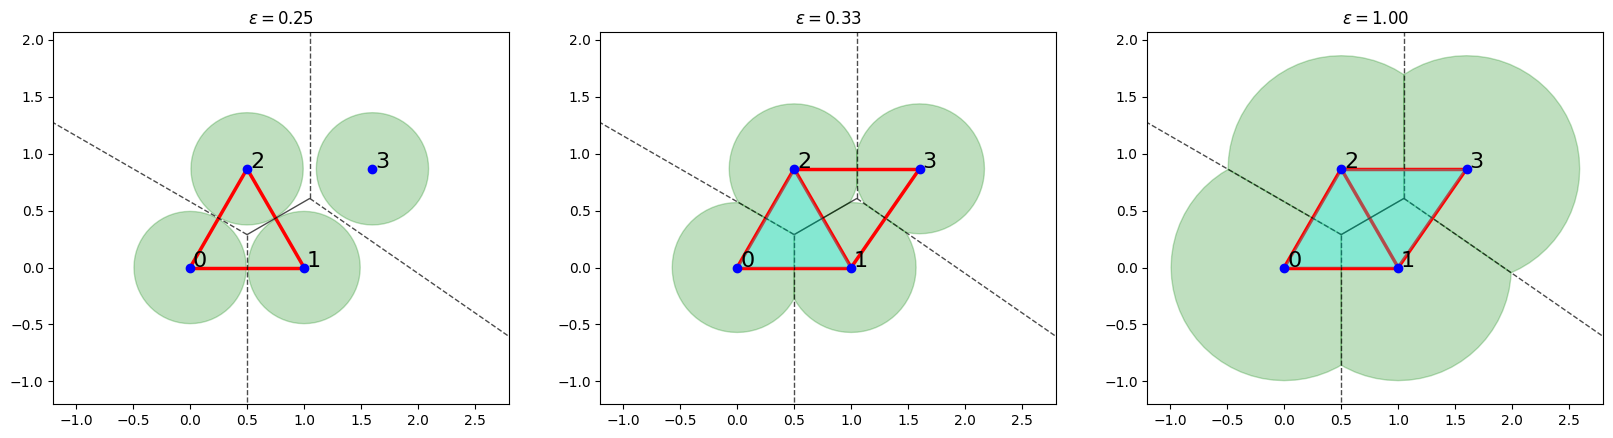

In [6]:
zero_simplices = [(0, 0), (1, 0), (1/2, np.sqrt(3)/2), (1.6, np.sqrt(3)/2)]

x_coords = [p[0] for p in zero_simplices]
y_coords = [p[1] for p in zero_simplices]
x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)

epsilons = [0.2501, 0.3334, 1]

complex = AlphaComplex(zero_simplices)
simplicial_complex = complex.create_simplex_tree()

plot_number = 3


if plot_number == 1:
    epsilon = epsilons[1]
    name = "geometric_simplicial_complex"
    one_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 2 and eps < epsilon]
    two_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 3 and eps < epsilon]
    plot_points_and_lines_with_simplices(zero_simplices, one_simplices, two_simplices, np.sqrt(epsilon), draw_circles=False, fig_name=name)

elif plot_number == 2:
    fig, ax = plt.subplots(1, 3, figsize=(16, 16))
    name = "cech_example"
    for i, epsilon in enumerate([0.2501, 0.3334, 1]):
        one_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 2 and eps < epsilon]
        two_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 3 and eps < epsilon]
        if i == 2:
            one_simplices.append([0, 3])
            two_simplices.append([0, 1, 3])
            two_simplices.append([0, 2, 3])

        plot_points_and_lines_with_simplices(zero_simplices, one_simplices, two_simplices, np.sqrt(epsilon), draw_circles=True, fig_name=name, ax=ax[i])
        padding = max(epsilons)*1.2
        ax[i].set_xlim([x_min - padding, x_max + padding])
        ax[i].set_ylim([y_min - padding, y_max + padding])
        ax[i].set_title(r"$\epsilon=$" + f"{epsilon:.2f}")
        ax[i].grid(False)

        fig.savefig(f"{name}.svg", format="svg", dpi=1000, bbox_inches='tight')

elif plot_number == 3:
    fig, ax = plt.subplots(1, 3, figsize=(20, 16))
    name = "alpha_example"
    for i, epsilon in enumerate([0.2501, 0.3334, 1]):
        one_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 2 and eps < epsilon]
        two_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 3 and eps < epsilon]

        plot_points_and_lines_with_simplices(zero_simplices, one_simplices, two_simplices, np.sqrt(epsilon), draw_circles=True, fig_name=name, alpha=True, ax=ax[i])
        padding = max(epsilons)*1.2
        ax[i].set_xlim([x_min - padding, x_max + padding])
        ax[i].set_ylim([y_min - padding, y_max + padding])
        ax[i].set_title(r"$\epsilon=$" + f"{epsilon:.2f}")
        ax[i].grid(False)

        fig.savefig(f"{name}.svg", format="svg", dpi=1000, bbox_inches='tight')

elif plot_number == 4:
    fig, ax = plt.subplots()
    name = "voronoi_example"
    plot_voronoi_diagram(zero_simplices+[(0.6, 0.45)], ax, cmap="viridis")
    fig.savefig(f"{name}.svg", format="svg", dpi=1000, bbox_inches='tight')

In [7]:
two_simplices

[[0, 1, 2], [1, 2, 3]]

In [8]:
epsilon = 0.34
zero_simplices = [(0, 0), (1, 0), (1/2, np.sqrt(3)/2), (1.6, np.sqrt(3)/2)]

complex = AlphaComplex(zero_simplices)
simplicial_complex = complex.create_simplex_tree()
simplicial_complex.compute_persistence()
pers = simplicial_complex.persistence()

points = set()
for dim, (birth, death) in pers:
    if dim == 1:
        points.add(birth)
        points.add(death)
points

{0.25, 0.3025000000000001, 0.3333333333333333, 0.37}

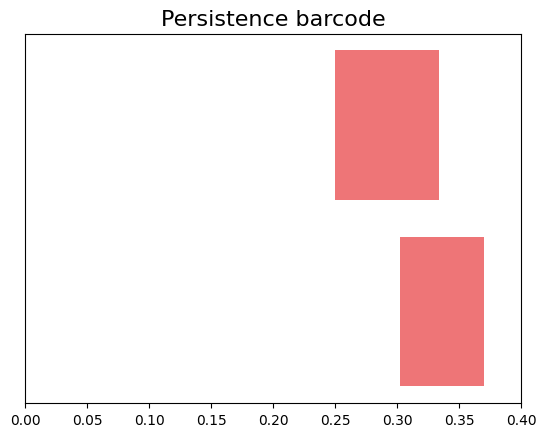

In [19]:
import gudhi

simplicial_complex.persistence()
aa: plt.Axes = gudhi.plot_persistence_barcode(simplicial_complex.persistence_intervals_in_dimension(1))
aa.set_xlim(left=0, right=0.4)
plt.savefig(f"barcodes.svg", format="svg", dpi=1000, bbox_inches='tight')

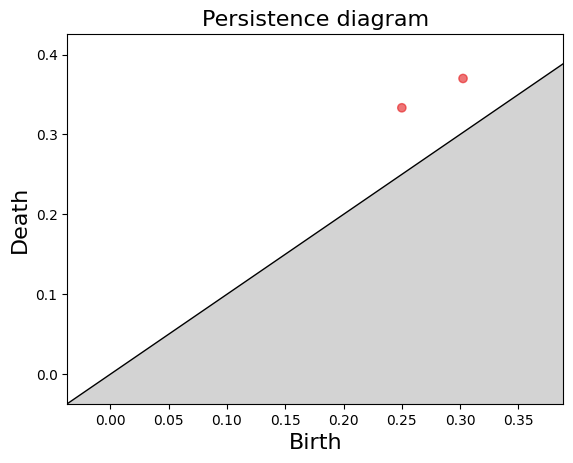

In [22]:
from functions.gudhi_persistence_plotting import plot_persistence_diagram
plot_persistence_diagram(simplicial_complex.persistence_intervals_in_dimension(1))
plt.savefig(f"persistence_diagram.svg", format="svg", dpi=1000, bbox_inches='tight')

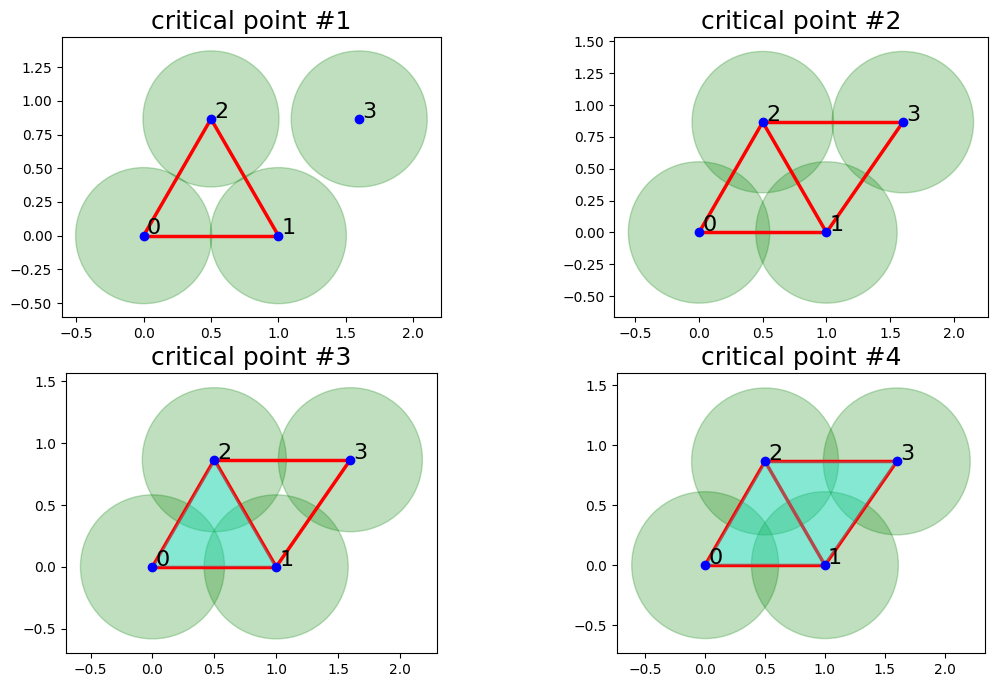

In [10]:
points = sorted(list(points))
fig, ax = plt.subplots(nrows=2, ncols=len(points)//2, figsize=(13, 8))

for i, epsilon in enumerate(points):
    x = i // 2
    y = i % 2
    one_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 2 and eps <= epsilon]
    two_simplices = [simplex for simplex, eps in simplicial_complex.get_simplices() if len(simplex) == 3 and eps <= epsilon]

    plot_points_and_lines_with_simplices(zero_simplices, one_simplices, two_simplices, np.sqrt(epsilon)+0.005, ax=ax[x, y], draw_circles=True)
    ax[x, y].grid(False)
    ax[x, y].set_title(f"critical point #{i+1}", fontsize=18)
    fig.savefig("critical_point_example.svg", format="svg", dpi=1000, bbox_inches='tight')

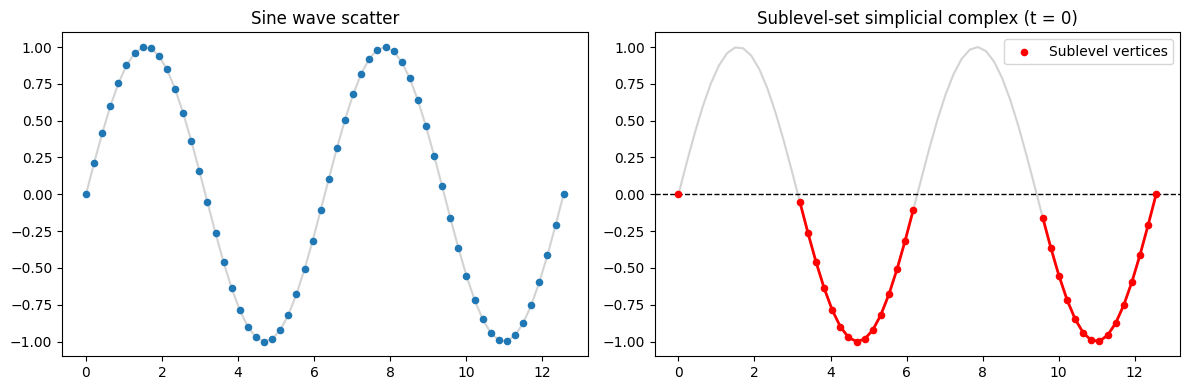

In [16]:
n = 60
x = np.linspace(0, 4*np.pi, n)  # indices/time
y = np.sin(x)                   # values
t = 0.0                         # threshold for sublevel set
in_sublevel = y <= t            # Boolean mask for sublevel set

# --- Create the figure and subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# === Left subplot: sine wave scatter ===
axes[0].plot(x, y, color="lightgray", linewidth=1.5, label="Sine wave")
axes[0].scatter(x, y, s=20, zorder=3)
#axes[0].axhline(t, linestyle="--", color="black", linewidth=1)
axes[0].set_title("Sine wave scatter")

# === Right subplot: sublevel set simplicial complex ===
# Plot the sine wave in light gray
axes[1].plot(x, y, color="lightgray", linewidth=1.5)

# Highlight sublevel set vertices
axes[1].scatter(x[in_sublevel], y[in_sublevel], color="red", s=20, zorder=3, label="Sublevel vertices")

# Draw edges (1-simplices) between consecutive sublevel set vertices
for i in range(n - 1):
    if in_sublevel[i] and in_sublevel[i + 1]:
        axes[1].plot([x[i], x[i+1]], [y[i], y[i+1]], color="red", linewidth=2)

# Threshold line
axes[1].axhline(t, linestyle="--", color="black", linewidth=1)

axes[1].set_title("Sublevel-set simplicial complex (t = 0)")
axes[1].legend()

plt.tight_layout()
plt.show()

fig.savefig("sublevel_set.svg", format="svg", dpi=1000, bbox_inches='tight')